# Imports and setup

In [1]:
import os
import sys
import time
import numpy as np
import scipy as sp
from scipy import integrate
import scipy.interpolate
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = os.path.abspath(os.path.join('../../examples/'))
if module_path not in sys.path:
    sys.path.append(module_path)

data_dir = '../../../data/'
system   = 'LinearAdvection-dt1e-2' 
prob_dir = os.path.join(data_dir, system)

## Linear Advection Problem

$$
u_t + c u_x = 0 \\
u(x,0) = \exp(-x^2) \\
(x,t) \in [-1,1] \times (0,T)
$$
with periodic boundary conditions.

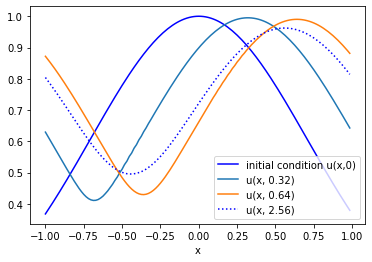

In [2]:
from linear_advection import Advection1D

dt = 0.01
problem = Advection1D(c=1, domain=[-1,1], nx=129)
utrue = problem.solve_ivp(dt=dt, t_start=0.0, t_stop=2.56).y

plt.plot(problem.x, utrue[:,0], 'b-', label='initial condition u(x,0)')
plt.plot(problem.x, utrue[:,32], label=f'u(x, {dt*32})')
plt.plot(problem.x, utrue[:,64], label=f'u(x, {dt*64})')
plt.plot(problem.x, utrue[:,-1], 'b:', label=f'u(x, 2.56)')
plt.xlabel('x')
plt.legend()
plt.show()

# Data Generation

In [25]:
# adjustable parameters
dx = problem.dx # spatial mesh spacing
cfl = dt/dx

noise = 0.      # for study of noisy measurements, we use noise=0.01, 0.02; otherwise we leave it as 0.
n_forward = 4
total_steps = 64 * n_forward
t = np.linspace(0, (total_steps)*dt, total_steps+1)

print(total_steps*dt)

2.56


In [7]:
# simulation parameters
np.random.seed(2)
n = problem.nx

# dataset 
n_train = 1280
n_val = 128
n_test = 128

In [8]:
print( 'training dataset size: {:.4f} GB'.format(n_train*(total_steps+1)*n*np.dtype(float).itemsize/1e9) )

# simulate training trials
train_data = np.zeros((n_train, total_steps+1, n))
print('generating training trials ...')
for i in tqdm(range(n_train)):
    u_init = np.random.uniform(-2.0, 2.0)*Advection1D.initial_condition(problem.x)
    problem_i = Advection1D(c=problem.c, domain=problem.domain,
                            nx=problem.nx+1, u_init=u_init)
    sol = problem_i.solve_ivp(dt=dt, t_start=0.0, t_stop=2.56)
    train_data[i, :, :] = sol.y.T

# simulate validation trials 
val_data = np.zeros((n_val, total_steps+1, n))
print('generating validation trials ...')
for i in tqdm(range(n_val)):
    u_init = np.random.uniform(-1.0, 1.0)*Advection1D.initial_condition(problem.x) # make sure this initial condition is in the training set
    problem_i = Advection1D(c=problem.c, domain=problem.domain,
                            nx=problem.nx+1, u_init=u_init)
    sol = problem_i.solve_ivp(dt=dt, t_start=0.0, t_stop=2.56)
    val_data[i, :, :] = sol.y.T
    
# simulate test trials
test_data = np.zeros((n_test, total_steps+1, n))
print('generating testing trials ...')
for i in tqdm(range(n_test)):
    u_init = np.random.uniform(-1.0, 1.0)*Advection1D.initial_condition(problem.x)
    problem_i = Advection1D(c=problem.c, domain=problem.domain,
                            nx=problem.nx+1, u_init=u_init)
    sol = problem_i.solve_ivp(dt=dt, t_start=0.0, t_stop=2.56)
    test_data[i, :, :] = sol.y.T
        
# add noise
train_data += noise*train_data.std(1).mean(0)*np.random.randn(*train_data.shape)
val_data += noise*val_data.std(1).mean(0)*np.random.randn(*val_data.shape)
test_data += noise*test_data.std(1).mean(0)*np.random.randn(*test_data.shape)

# save data
np.save(os.path.join(prob_dir, 'train_noise{}.npy'.format(noise)), train_data)
np.save(os.path.join(prob_dir, 'val_noise{}.npy'.format(noise)), val_data)
np.save(os.path.join(prob_dir, 'test_noise{}.npy'.format(noise)), test_data)
        

training dataset size: 0.3369 GB
generating training trials ...


  0%|          | 0/1280 [00:00<?, ?it/s]

generating validation trials ...


  0%|          | 0/128 [00:00<?, ?it/s]

generating testing trials ...


  0%|          | 0/128 [00:00<?, ?it/s]

# Training

In [4]:
import ResNet as net

In [31]:
# adjustables

ks = list(range(7))           # model index: should be in {0, 2, ..., 10}
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02
lr = 1e-3                     # learning rate
max_epoch = 100000            # the maximum training epoch 
tol = 1e-7                    # early stopping tolerance
batch_size = 128              # training batch size
arch = [n, 512, 512, 512, n]  # architecture of the neural network

In [32]:
# paths
data_dir = os.path.join('data/', system)
model_dir = os.path.join('models/', system)

# global const
step_sizes = [2**k for k in ks]
n_forward = 4

In [33]:
# load data
train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
n_train = train_data.shape[0]
n_val = val_data.shape[0]
n_test = test_data.shape[0]

for step_size in step_sizes:
  # create dataset object
  dataset = net.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)

  model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)

  # create/load model object
  try:
      print('try to load model {} ...'.format(model_name))
      device = 'cuda' if torch.cuda.is_available() else 'cpu'
      model = torch.load(os.path.join(model_dir, model_name), map_location=device)
      model.device = device
  except:
      print('{} not found, will create ...'.format(model_name))
      model = net.ResNet(arch=arch, dt=dt, step_size=step_size)

  # training
  model.train_net(dataset, max_epoch=max_epoch, batch_size=batch_size, lr=lr,
                  model_path=os.path.join(model_dir, model_name), tol=tol)

try to load model model_D1_noise0.0.pt ...
epoch 1000, training loss 3.388323079889233e-07, validation loss 1.688051298742721e-07
(--> new model saved @ epoch 1000)
epoch 2000, training loss 4.3963481743958255e-07, validation loss 2.908151373048895e-07
epoch 3000, training loss 6.620930435019545e-07, validation loss 3.6579680795512104e-07
epoch 4000, training loss 1.785928702702222e-07, validation loss 1.31081037579861e-07
(--> new model saved @ epoch 4000)
epoch 5000, training loss 7.074629593262216e-08, validation loss 2.6499229477394692e-08
(--> new model saved @ epoch 5000)
--> model has reached an accuracy of 1e-07! Finished training!
try to load model model_D2_noise0.0.pt ...
epoch 1000, training loss 3.020513759111054e-07, validation loss 1.0947553619189421e-07
(--> new model saved @ epoch 1000)
epoch 2000, training loss 1.1935669874674204e-07, validation loss 5.98016782760169e-08
(--> new model saved @ epoch 2000)
--> model has reached an accuracy of 1e-07! Finished training!
-

# Loading the models

In [3]:
import ResNet as net

In [4]:
# path
model_dir = os.path.join('../../../models/', system)

# global const
ks = list(range(7))
step_sizes = [2**k for k in ks]

In [5]:
# load validation set and test set
val_data = np.load(os.path.join(prob_dir, 'val_noise0.0.npy'))
test_data = np.load(os.path.join(prob_dir, 'test_noise0.0.npy'))

In [6]:
# load models
models = []
for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    models.append(torch.load(os.path.join(model_dir, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load model_D1.pt
load model_D2.pt
load model_D4.pt
load model_D8.pt
load model_D16.pt
load model_D32.pt
load model_D64.pt


# Running with MGRIT + HiTS

In [7]:
from pymgrit import Mgrit
from mgrit_hits import VectorHits, MgritHits

In [16]:
# xinit = torch.tensor(test_data[0, 0, :]).float()
xinit = torch.tensor(Advection1D.initial_condition(problem.x)).float()

tf = 2.56
lvl = 6

multilevel_structure = [
  MgritHits(model=None, stepfn=problem.step_backward_euler,
            ic=xinit, t_start=0, t_stop=tf, nt=257),
  
  MgritHits(model=models[3], ic=xinit, t_start=0, t_stop=tf, nt=256//(2**3)+1),

  MgritHits(model=models[4], ic=xinit, t_start=0, t_stop=tf, nt=256//(2**4)+1),

  MgritHits(model=models[5], ic=xinit, t_start=0, t_stop=tf, nt=256//(2**5)+1),

  MgritHits(model=models[lvl], ic=xinit, t_start=0, t_stop=tf, nt=256//(2**lvl)+1),
]


In [17]:
sol = []
def output_function(self):
  sol.append([self.u[0][i].get_values().numpy() for i in self.index_local[0]])

mgrit = Mgrit(problem=multilevel_structure, tol=1e-5, cycle_type='V', max_iter=50,
              output_fcn=output_function, output_lvl=1, logging_lvl=20)

INFO - 04-06-21 15:54:24 - Start setup
INFO - 04-06-21 15:54:25 - Setup took 0.22334504127502441 s


In [18]:
info = mgrit.solve()

INFO - 04-06-21 15:54:27 - Start solve
INFO - 04-06-21 15:54:27 - iter 1  | conv: 91.01324462890625       | conv factor: -                     | runtime: 0.3141815662384033 s   
INFO - 04-06-21 15:54:27 - iter 2  | conv: 444.92071533203125      | conv factor: 4.8885271275201       | runtime: 0.26583170890808105 s  
INFO - 04-06-21 15:54:28 - iter 3  | conv: 1472.100830078125       | conv factor: 3.308681253421836     | runtime: 0.27498483657836914 s  
INFO - 04-06-21 15:54:28 - iter 4  | conv: 3418.817138671875       | conv factor: 2.3224069091044783    | runtime: 0.26740145683288574 s  
INFO - 04-06-21 15:54:28 - iter 5  | conv: 5655.16015625           | conv factor: 1.6541277075868668    | runtime: 0.2749667167663574 s   
INFO - 04-06-21 15:54:28 - iter 6  | conv: 6676.203125             | conv factor: 1.1805506724016575    | runtime: 0.2662367820739746 s   
INFO - 04-06-21 15:54:29 - iter 7  | conv: 5581.11669921875        | conv factor: 0.8359716735279455    | runtime: 0.2774126529

In [19]:
sol = np.array(sol)
sol = sol.reshape((sol.shape[1], sol.shape[2])).T

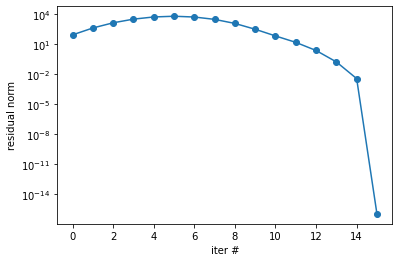

In [22]:
res = info['conv']
iters = np.arange(0, res.size+1)
plt.semilogy(iters, np.pad(res, (0,1), constant_values=1e-16), 'o-')
plt.xlabel('iter #')
plt.ylabel('residual norm')
plt.show()

Text(0.5, 0, 'x')

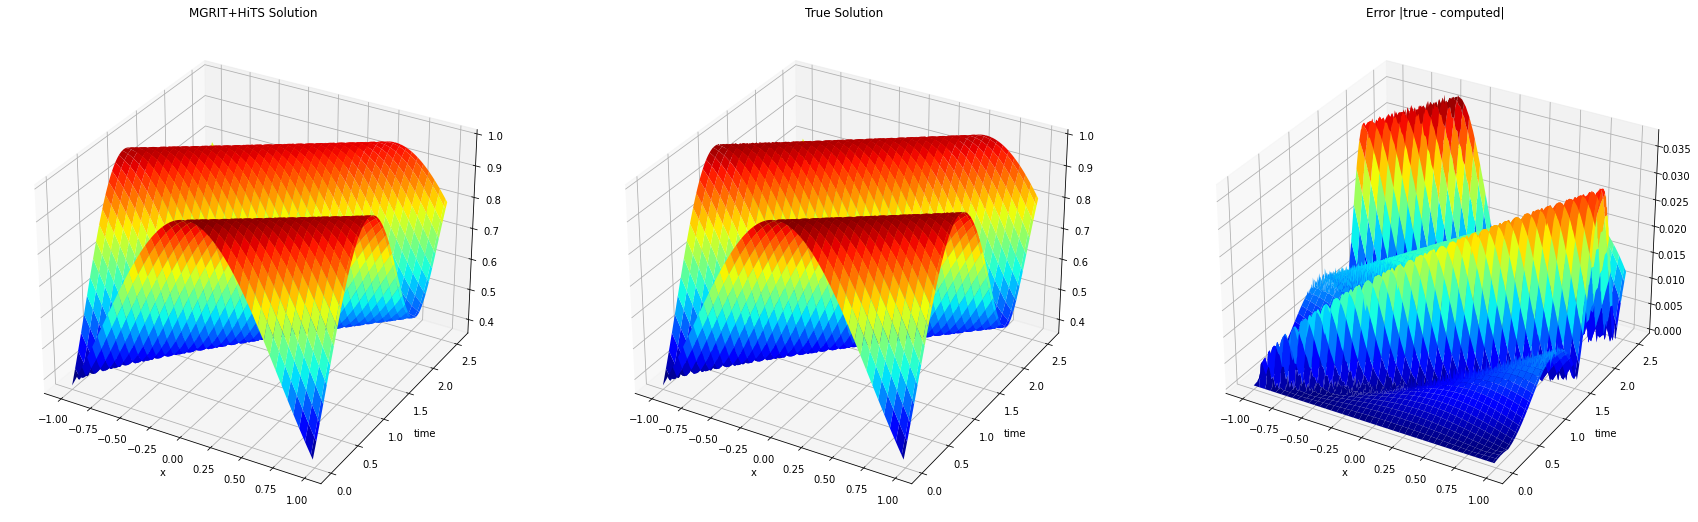

In [64]:
dt = 0.01
idx = 36

# plt.plot(problem.x, utrue[:,0], 'b-', label='initial condition u(x,0)')
# plt.plot(problem.x, utrue[:,idx], 'b-', label=f'utrue(x, {dt*idx})')
# plt.plot(problem.x, sol[:,idx], 'b:', label=f'upred(x, {dt*idx})')
# plt.xlabel('x')
# plt.legend()
# plt.show()

X, T = np.meshgrid(t[:-1], problem.x)

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,3,1,projection='3d')
ax.plot_surface(T, X, sol[:,:-1], cmap='jet')
ax.set_title('MGRIT+HiTS Solution')
ax.set_ylabel('time')
ax.set_xlabel('x')

ax = fig.add_subplot(1,3,2,projection='3d')
ax.plot_surface(T, X, utrue[:,:-1], cmap='jet')
ax.set_title('True Solution')
ax.set_ylabel('time')
ax.set_xlabel('x')

ax = fig.add_subplot(1,3,3,projection='3d')
ax.plot_surface(T, X, np.abs(sol[:,:-1]-utrue[:,:-1]), cmap='jet')
ax.set_title('Error |true - computed|')
ax.set_ylabel('time')
ax.set_xlabel('x')